In [1]:
# Import the required packages
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, f1_score, recall_score,classification_report,roc_curve, auc 

In [4]:
#pip install librosa

we will be using [spela](https://github.com/kongkip/spela) a package used to compute speech features 
e.g spectrograms and melspectrograms implemented using tf.keras to take advantage of GPU during computations

In [2]:
# a package to compute speech features, implemented using tf.keras
try:
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram
except:
    !pip install spela
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram

In [3]:
# disable eager execution, my model couldn't train well while on eager mode
tf.compat.v1.disable_eager_execution()

In [4]:
# Get the data directories
data_dir = "D:/16000_pcm_speeches/"

In [5]:
# inspect the folders inside the dataset
os.listdir(data_dir)

['Benjamin_Netanyau',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela',
 'other',
 '_background_noise_']

In [6]:
# for now we are concerned with the four speakers
# lets get as a sample data from one of the speakers
nelson_madela = [item for item in os.listdir(data_dir + "Nelson_Mandela")]
nelson_madela[:10]

['0.wav',
 '1.wav',
 '10.wav',
 '100.wav',
 '1000.wav',
 '1001.wav',
 '1002.wav',
 '1003.wav',
 '1004.wav',
 '1005.wav']

In [7]:
# lets create a function that takes in a raw wavfile and computes a spectrogram then plots it
def compute_spectrogram_melspectrogram_and_plot(wav_dir, compute_type):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
        wav_decoder, feed_dict={
            wav_filename_placeholder: wav_dir
        }).audio.flatten()
        sess.close()
    # audio has a sample rate of 16000 and the produced wav has a shape of (16000, 1)
    # reshape to (1, 1600)
    wav = wav_data.reshape(1, 16000)
    wav_new = wav[np.newaxis, :] # introduce a new axis to have a shape of (1, 1, 16000)
    height = wav_new.shape[1]
    width = wav_new.shape[2]
    # create a model to compute spectrogram
    model = tf.keras.Sequential() 
    if compute_type == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(height, width),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif compute_type == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(height, width), return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
   
    # producing a spectrogram/melspectrogram from the model
    pred = model.predict(x=wav_new)

    if tf.keras.backend.image_data_format() == "channel_first":
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]

    # show the spectrogram/melspectrogram
    librosa.display.specshow(result, y_axis='linear', sr=16000)

D:\anaconda\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


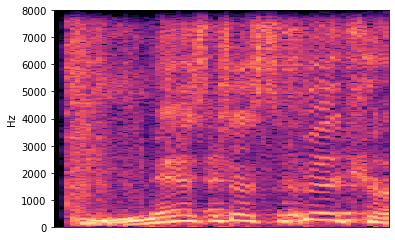

In [8]:
compute_spectrogram_melspectrogram_and_plot(data_dir + "Nelson_Mandela/" + nelson_madela[0], "spectrogram")

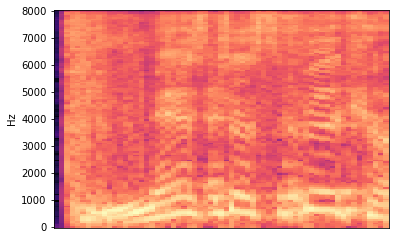

In [9]:
compute_spectrogram_melspectrogram_and_plot(data_dir + "Nelson_Mandela/" + nelson_madela[0], "melspectrogram")

# Process training dataset

In [10]:
# get wav paths
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [11]:
nelson_mandela_paths = get_wav_paths("Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( 'Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("Julia_Gillard")

In [12]:
# load the data
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir +speaker + "/"+ wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 16000))
        sess.close()
    return wav_data
    

In [13]:
# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels


In [14]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "Julia_Gillard", 4) 

100%|██████████████████████████████████████████████████████████████████████████████| 1501/1501 [00:15<00:00, 98.30it/s]


In [15]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [16]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels

In [17]:
# split the dataset into trainin and testing set\
train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.2)

In [34]:
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [19]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [20]:
del nelson_mandela_wavs, nelson_mandela_labels,margaret_thatcher_wavs, margaret_thatcher_labels,benjamin_netanyau_wavs, benjamin_netanyau_labels,
del jens_stoltenberg_wavs, jens_stoltenberg_labels,julia_gillard_wavs, julia_gillard_labels

# Create a simple model

In [21]:
import os, shutil
import numpy as np

from matplotlib import image, pyplot
from skimage.transform import resize


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, f1_score, recall_score,classification_report,roc_curve, auc 
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm


In [24]:
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(1, 16000),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(5, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
static_stft (Spectrogram)    (None, 257, 63, 1)        263168    
_________________________________________________________________
conv2d (Conv2D)              (None, 255, 61, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 30, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 243840)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               62423296  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

In [26]:
model.fit(x=train_x, y=train_y, epochs=10, batch_size= 128 ,validation_split = 0.2)

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - ETA: 0s - loss: 353.0207 - accuracy: 0.2438

C:\Users\NITISH\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4800/4800 [==============================] - 42s 9ms/sample - loss: 353.0207 - accuracy: 0.2438 - val_loss: 24.7615 - val_accuracy: 0.3417
Epoch 2/10
4800/4800 [==============================] - 40s 8ms/sample - loss: 8.0095 - accuracy: 0.4592 - val_loss: 2.3290 - val_accuracy: 0.5483
Epoch 3/10
4800/4800 [==============================] - 40s 8ms/sample - loss: 0.8346 - accuracy: 0.7890 - val_loss: 0.3866 - val_accuracy: 0.8600
Epoch 4/10
4800/4800 [==============================] - 40s 8ms/sample - loss: 0.2817 - accuracy: 0.9081 - val_loss: 0.2676 - val_accuracy: 0.9200
Epoch 5/10
4800/4800 [==============================] - 40s 8ms/sample - loss: 0.0702 - accuracy: 0.9750 - val_loss: 0.4910 - val_accuracy: 0.8592
Epoch 6/10
4800/4800 [==============================] - 40s 8ms/sample - loss: 0.0194 - accuracy: 0.9948 - val_loss: 0.2498 - val_accuracy: 0.9242
Epoch 7/10
4800/4800 [==============================] - 40s 8ms/sample - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.2091 - 

In [27]:
prediction_prob1 = model.predict(test_x,verbose=1)
y_pred=np.round(prediction_prob1)

In [28]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

In [29]:
print(accuracy_score(test_y,y_pred))
print(precision_score(test_y,y_pred,average='weighted'))
print(recall_score(test_y,y_pred,average='weighted'))
print(f1_score(test_y,y_pred,average='weighted'))
#print(confusion_matrix(y_test_oh,y_pred))
print(classification_report(test_y,y_pred))

0.9246666666666666
0.93409189843589
0.9246666666666666
0.9292128497191385
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       314
           1       0.94      0.93      0.94       311
           2       0.90      0.91      0.90       291
           3       0.94      0.89      0.92       303
           4       0.91      0.90      0.91       281

   micro avg       0.93      0.92      0.93      1500
   macro avg       0.93      0.92      0.93      1500
weighted avg       0.93      0.92      0.93      1500
 samples avg       0.92      0.92      0.92      1500



C:\Users\NITISH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


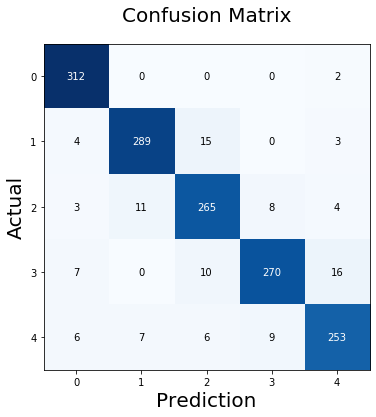

In [30]:
cf = confusion_matrix(test_y.argmax(axis = 1),y_pred.argmax(axis = 1))
fig, ax = plot_confusion_matrix(conf_mat=cf, figsize=(9, 6), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

In [22]:

model1 = Sequential()

model1.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(1 , 16000),return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
   

model1.add(Conv2D(64, (3, 3), activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(256, activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(5, activation="softmax"))


model1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 melgram (Melspectrogram)    (None, 128, 63, 1)        296064    
                                                                 
 conv2d (Conv2D)             (None, 126, 61, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 30, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 120960)            0         
                                                                 
 dense (Dense)               (None, 256)               30966016  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                      

In [24]:
model1.fit(x=train_x, y=train_y, epochs=5, validation_split = 0.2)

Train on 4800 samples, validate on 1200 samples
Epoch 1/5
4800/4800 [==============================] - ETA: 0s - loss: 4.0912 - accuracy: 0.6544

D:\anaconda\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4800/4800 [==============================] - 70s 15ms/sample - loss: 4.0912 - accuracy: 0.6544 - val_loss: 1.1277 - val_accuracy: 0.7350
Epoch 2/5
4800/4800 [==============================] - 60s 12ms/sample - loss: 0.7139 - accuracy: 0.8354 - val_loss: 0.5513 - val_accuracy: 0.8658
Epoch 3/5
4800/4800 [==============================] - 55s 12ms/sample - loss: 0.7506 - accuracy: 0.8394 - val_loss: 1.2448 - val_accuracy: 0.8158
Epoch 4/5
4800/4800 [==============================] - 55s 12ms/sample - loss: 0.5735 - accuracy: 0.8846 - val_loss: 0.4772 - val_accuracy: 0.8900
Epoch 5/5
4800/4800 [==============================] - 55s 11ms/sample - loss: 0.2244 - accuracy: 0.9369 - val_loss: 0.3866 - val_accuracy: 0.9033


In [25]:
prediction_prob1 = model1.predict(test_x,verbose=1)
y_pred=np.round(prediction_prob1)

In [26]:
print(accuracy_score(test_y,y_pred))
print(precision_score(test_y,y_pred,average='weighted'))
print(recall_score(test_y,y_pred,average='weighted'))
print(f1_score(test_y,y_pred,average='weighted'))
#print(confusion_matrix(y_test_oh,y_pred))
print(classification_report(test_y,y_pred))

0.894
0.9107588371679679
0.894
0.8963392448033444
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       315
           1       0.95      0.95      0.95       311
           2       0.97      0.71      0.82       282
           3       0.87      0.94      0.90       296
           4       0.77      0.94      0.85       296

   micro avg       0.90      0.89      0.90      1500
   macro avg       0.91      0.89      0.89      1500
weighted avg       0.91      0.89      0.90      1500
 samples avg       0.89      0.89      0.89      1500



D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
cf = confusion_matrix(test_y.argmax(axis = 1),y_pred.argmax(axis = 1))
fig, ax = plot_confusion_matrix(conf_mat=cf, figsize=(9, 6), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

NameError: name 'plot_confusion_matrix' is not defined

In [56]:
from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

In [57]:
train_x[0].shape

(1, 16000)

In [58]:
train_y.shape

(6000, 5)

In [59]:
print(model1.layers)

[<spela.melspectrogram.Melspectrogram object at 0x000001E4A08DA188>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E49E357748>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001E49E357AC8>, <tensorflow.python.keras.layers.core.Flatten object at 0x000001E49E357FC8>, <tensorflow.python.keras.layers.core.Dense object at 0x000001E49E367048>, <tensorflow.python.keras.layers.core.Dense object at 0x000001E49E372B48>, <tensorflow.python.keras.layers.core.Dense object at 0x000001E49E37AF48>]


In [60]:
m1model = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)


In [27]:
m2model = Model(inputs=model1.input,outputs=model1.get_layer('dense_1').output)

In [63]:
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [64]:
m1_x_train = m1model.predict(train_x,verbose=1)
m1_x_test = m1model.predict(test_x,verbose=1)

m2_x_train = m2model.predict(train_x,verbose=1)
m2_x_test = m2model.predict(test_x,verbose=1)

In [28]:
m2_x_train = m2model.predict(train_x,verbose=1)
m2_x_test = m2model.predict(test_x,verbose=1)

D:\anaconda\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [65]:
print("Shape of model1 Train and Test DF : ",m1_x_train.shape," : ",m1_x_test.shape)
print("Shape of model2 Train and Test DF : ",m2_x_train.shape," : ",m2_x_test.shape)

Shape of model1 Train and Test DF :  (6000, 128)  :  (1500, 128)
Shape of model2 Train and Test DF :  (6000, 128)  :  (1500, 128)


In [31]:
def printMetrics(true,pred):
    print("Accuracy : ",accuracy_score(true, pred))
    print("Precision",precision_score(true, pred , average="weighted"))
    print("Recall : ",recall_score(true, pred , average="weighted"))
    print("F1-score : ",f1_score(true, pred, average="weighted"))
    print("Confusion Matrix : ")
    #print(confusion_matrix(true, pred))
    print(classification_report(true,pred))

In [32]:
np.shape(train_y)

(6000, 5)

In [35]:
LR = LogisticRegression()
LR.fit(m1_x_train, train_y)
LRprob = LR.predict_proba(m1_x_test)
y_pred = LR.predict(m1_x_test)
print("Spectrogram")
printMetrics(test_y,y_pred)


Spectrogram
Accuracy :  0.20466666666666666
Precision 0.20551352727781008
Recall :  0.20466666666666666
F1-score :  0.2042959150798819
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.18      0.19      0.19       315
           1       0.22      0.22      0.22       311
           2       0.21      0.24      0.22       282
           3       0.22      0.18      0.20       296
           4       0.19      0.18      0.19       296

    accuracy                           0.20      1500
   macro avg       0.21      0.21      0.20      1500
weighted avg       0.21      0.20      0.20      1500



D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
RF = RandomForestClassifier()
RF.fit(m1_x_train, train_y)
RFprob = RF.predict_proba(m1_x_test)
y_pred = RF.predict(m1_x_test)
print("Spectrogram")
printMetrics(test_y,y_pred)

RF = RandomForestClassifier()
RF.fit(m2_x_train, train_y)
CS_RFprob = RF.predict_proba(m2_x_test)
y_pred = RF.predict(m2_x_test)
print("Melspectrogram")
printMetrics(test_y,y_pred)

Spectrogram
Accuracy :  0.21266666666666667
Precision 0.21367815484084512
Recall :  0.21266666666666667
F1-score :  0.21266670463364948
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.25      0.24      0.24       315
           1       0.22      0.23      0.23       311
           2       0.19      0.22      0.20       282
           3       0.20      0.19      0.20       296
           4       0.20      0.18      0.19       296

    accuracy                           0.21      1500
   macro avg       0.21      0.21      0.21      1500
weighted avg       0.21      0.21      0.21      1500

Melspectrogram
Accuracy :  0.9233333333333333
Precision 0.9243152830079217
Recall :  0.9233333333333333
F1-score :  0.923591979091653
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       315
           1       0.95      0.95      0.95       311
           2       0.88      0.91     

In [71]:
DT = DecisionTreeClassifier()
DT.fit(m1_x_train, train_y)
DTprob = DT.predict_proba(m1_x_test)
y_pred = DT.predict(m1_x_test)
print("Spectrogram")
printMetrics(test_y,y_pred)

DT = DecisionTreeClassifier()
DT.fit(m2_x_train, train_y)
CS_DTprob = DT.predict_proba(m2_x_test)
y_pred = DT.predict(m2_x_test)
print("Melspectrogram")
printMetrics(test_y,y_pred)

Spectrogram
Accuracy :  0.9193333333333333
Precision 0.9195086096906995
Recall :  0.9193333333333333
F1-score :  0.9193168460954815
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       314
           1       0.92      0.93      0.92       311
           2       0.88      0.88      0.88       291
           3       0.90      0.93      0.92       303
           4       0.91      0.88      0.89       281

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500

Melspectrogram
Accuracy :  0.876
Precision 0.8770536265808809
Recall :  0.876
F1-score :  0.876399650528913
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       314
           1       0.92      0.91      0.92       311
           2       0.82      0.85      0.84       291
           3  

In [72]:
KNN = KNeighborsClassifier()
KNN.fit(m1_x_train, train_y)
KNNprob = KNN.predict_proba(m1_x_test)
y_pred = KNN.predict(m1_x_test)
print("Spectrogram")
printMetrics(test_y,y_pred)

KNN = KNeighborsClassifier()
KNN.fit(m2_x_train, train_y)
CS_KNNprob = KNN.predict_proba(m2_x_test)
y_pred = KNN.predict(m2_x_test)
print("Melspectrogram")
printMetrics(test_y,y_pred) 

Spectrogram
Accuracy :  0.9513333333333334
Precision 0.9514869801477004
Recall :  0.9513333333333334
F1-score :  0.9512890598972439
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       314
           1       0.93      0.95      0.94       311
           2       0.92      0.94      0.93       291
           3       0.96      0.94      0.95       303
           4       0.96      0.92      0.94       281

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500

Melspectrogram
Accuracy :  0.924
Precision 0.9246750289271799
Recall :  0.924
F1-score :  0.924032186967844
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       314
           1       0.90      0.95      0.92       311
           2       0.88      0.89      0.89       291
           3  

In [38]:
y_train = train_y
y_test = test_y

In [74]:
GNB = GaussianNB()
GNB.fit(m1_x_train, y_train)
GNBprob = GNB.predict_proba(m1_x_test)
y_pred = GNB.predict(m1_x_test)
print("Spectrogram")
printMetrics(y_test,y_pred)

GNB = GaussianNB()
GNB.fit(m2_x_train, y_train)
CS_GNBprob = GNB.predict_proba(m2_x_test)
y_pred = GNB.predict(m2_x_test)
print("Melspectrogram")
printMetrics(y_test,y_pred)

Spectrogram
Accuracy :  0.6886666666666666
Precision 0.6808675333812213
Recall :  0.6886666666666666
F1-score :  0.6730458733955815
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       314
           1       0.64      0.71      0.67       311
           2       0.53      0.27      0.36       291
           3       0.65      0.80      0.72       303
           4       0.67      0.83      0.74       281

    accuracy                           0.69      1500
   macro avg       0.68      0.69      0.67      1500
weighted avg       0.68      0.69      0.67      1500

Melspectrogram
Accuracy :  0.8393333333333334
Precision 0.849375171650698
Recall :  0.8393333333333334
F1-score :  0.8372435630120485
Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       314
           1       0.87      0.96      0.91       311
           2       0.93      0.63      0.7

In [ ]:
LSVM = svm.SVC(kernel='linear',probability=True)
LSVM.fit(m1_x_train, y_train)
LSVMprob = LSVM.predict_proba(m1_x_test)
y_pred = LSVM.predict(m1_x_test)
print("Spectrogram")
printMetrics(y_test,y_pred)

LSVM = svm.SVC(kernel='linear',probability=True)
LSVM.fit(m2_x_train, y_train)
CS_LSVMprob = LSVM.predict_proba(m2_x_test)
y_pred = LSVM.predict(m2_x_test)
print("Melspectrogram")
printMetrics(y_test,y_pred)

In [36]:
import librosa
import numpy

In [29]:

m1_x_train = librosa.feature.mfcc(S=m2_x_train, sr=16000, n_mfcc=6000)

In [30]:

m1_x_test = librosa.feature.mfcc(S=m2_x_test, sr=16000, n_mfcc=1500)